# BERT Example
- Largely based on https://n8henrie.com/2021/08/writing-a-transformer-classifier-in-pytorch/

### Imports and Settings

In [1]:
%load_ext autoreload
%autoreload 2

import os, gc
import numpy as np
import random
from tqdm import tqdm
import torch
from models.cnn_nlp import CNN_NLP
from pympler import asizeof
%matplotlib inline


import json


import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader 
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Sampler

from sqlalchemy.orm import Session
from sqlalchemy import create_engine, select, MetaData, Table, and_

with open ('../settings.json') as f:
    settings = json.load(f)

DATA_DIR = os.path.join(settings['data_path'], 'classifier')
os.makedirs(DATA_DIR, exist_ok=True)
CHECKPOINT_DIR = os.path.join(DATA_DIR, "model_data")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
CHECKPOINT_PREFIX = os.path.join(CHECKPOINT_DIR, "bert-example")

db_uri = settings['sqlalchemy_database_uri']

RANDOM_SEED = 4321
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

VOCABULARY_SIZE = 20_000
MAX_LENGTH = 20480 * 2
LEARNING_RATE = 0.05
EMBEDDING_DIM = 128
DROPOUT = 0.1
BATCH_SIZE = 8
NUM_EPOCHS = 15
NUM_CLASSES = 4
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
# Enable synchronous CUDA execution for better error reporting
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Enable device-side assertions in CUDA kernels
os.environ['TORCH_USE_CUDA_DSA'] = '1'

# Confirm the variables are set
print("CUDA_LAUNCH_BLOCKING =", os.getenv('CUDA_LAUNCH_BLOCKING'))
print("TORCH_USE_CUDA_DSA =", os.getenv('TORCH_USE_CUDA_DSA'))


CUDA_LAUNCH_BLOCKING = 1
TORCH_USE_CUDA_DSA = 1


### Load Test Data

In [3]:
from datasets import load_dataset
REPORT_DIR = os.path.join(DATA_DIR, "report_data")

file_paths = [  os.path.join(REPORT_DIR, 'json_0.json'),
                os.path.join(REPORT_DIR, 'json_19.json')]

dataset = load_dataset('json', data_files=file_paths)['train']
print(dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 2000
})


### Split Data

In [4]:
# First, split into 80% train and 20% (validation + test), with shuffling
train_test_split = dataset.train_test_split(test_size=0.2, seed=42, shuffle=True)
train_dataset = train_test_split['train']
temp_dataset = train_test_split['test']

# Then, split the 20% temp_dataset into 10% validation and 10% test, with shuffling
validation_test_split = temp_dataset.train_test_split(test_size=0.5, seed=42, shuffle=True)
validation_dataset = validation_test_split['train']
test_dataset = validation_test_split['test']

# Check the size and order of samples in each split
print(f"Train dataset: {len(train_dataset)} samples")
print(f"Validation dataset: {len(validation_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")

Train dataset: 1600 samples
Validation dataset: 200 samples
Test dataset: 200 samples


### Load Tokenizer

In [5]:
tokenizer_path = os.path.join(DATA_DIR, 'model_data', 'mal-reformer')
print(f"Tokenizer path: {tokenizer_path}")

import torch
from transformers import AutoTokenizer, ReformerForSequenceClassification

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
tokenizer.pad_token = "[PAD]"
tokenizer.cls_token = "[CLS]"
tokenizer.sep_token = "[SEP]"

Tokenizer path: /media/mike/data/gimc/classifier/model_data/mal-reformer


### Tokenizer Function

In [6]:
def tokenize_function(example):
    return tokenizer(
        example['text'],
        padding='max_length',
        truncation=True,
        max_length=MAX_LENGTH
    )

In [7]:
# Tokenize each split
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_validation_dataset = validation_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

### Create Dataloaders

In [8]:
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,SequentialSampler)

def data_loader(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE):
    train_inputs, val_inputs, test_inputs = [], [], []
    train_labels, val_labels, test_labels = [], [], []
    
    for i in tqdm(range(len(train_dataset)), desc="Tokenizing train dataset"):
        train_inputs.append(train_dataset[i]['input_ids'])
        train_labels.append(train_dataset[i]['label'])
    for i in tqdm(range(len(val_dataset)), desc="Tokenizing validation dataset"):
        val_inputs.append(val_dataset[i]['input_ids'])
        val_labels.append(val_dataset[i]['label'])
    for i in tqdm(range(len(test_dataset)), desc="Tokenizing test dataset"):
        test_inputs.append(test_dataset[i]['input_ids'])
        test_labels.append(test_dataset[i]['label'])

    # Convert data type to torch.Tensor
    train_inputs = torch.tensor(train_inputs)
    val_inputs = torch.tensor(val_inputs)
    test_inputs = torch.tensor(test_inputs)
    train_labels = torch.tensor(train_labels)
    val_labels = torch.tensor(val_labels)
    test_labels = torch.tensor(test_labels)
                                   
    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    # create DataLoader for test data
    test_data = TensorDataset(test_inputs, test_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
    return train_dataloader, val_dataloader, test_dataloader

In [9]:
train_dataloader, val_dataloader, test_dataloader = data_loader(tokenized_train_dataset, tokenized_validation_dataset, tokenized_test_dataset)

Tokenizing test dataset: 100%|██████████| 200/200 [00:09<00:00, 21.32it/s]


### Define Positional Encoder

In [10]:
from torch import nn
import math

class PositionalEncoding(nn.Module):
    """
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(self, d_model, max_length=MAX_LENGTH, dropout=DROPOUT):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_length, d_model)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

### Define Model

In [11]:
class TrnasformerClassifier(nn.Module):
    """
    Text classifier based on a pytorch TransformerEncoder.
    """

    def __init__(
        self,
        vocab_size=VOCABULARY_SIZE,
        d_model=EMBEDDING_DIM,
        max_length=MAX_LENGTH,
        nhead=8,
        dim_feedforward=2048,
        num_layers=6,
        dropout=0.1,
        activation="relu",
        classifier_dropout=DROPOUT,
    ):

        super().__init__()

        embeddings = nn.Embedding(vocab_size, d_model)
        assert d_model % nhead == 0, "nheads must divide evenly into d_model"

        self.emb = embeddings

        self.pos_encoder = PositionalEncoding(
            d_model=d_model,
            dropout=dropout,
            max_length=max_length,
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        self.classifier = nn.Linear(d_model, 2)
        self.d_model = d_model

    def forward(self, x):
        x = self.emb(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)

        return x

In [14]:
epochs = NUM_EPOCHS
embeddings = nn.Embedding(VOCABULARY_SIZE, EMBEDDING_DIM)
model = TrnasformerClassifier(
    nhead=4,  # the number of heads in the multiheadattention models
    dim_feedforward=25,  # the dimension of the feedforward network model in nn.TransformerEncoder
    num_layers=3,
    dropout=0.0,
    classifier_dropout=0.0,
).to(DEVICE)

criterion = nn.CrossEntropyLoss()

lr = 1e-4
optimizer = torch.optim.Adam(
    (p for p in model.parameters() if p.requires_grad), lr=lr
)

Epoch: 001/015 | Train: 94.12% | Validation: 94.00% | Elapsed: 31.94 min
Epoch: 002/015 | Train: 97.31% | Validation: 96.00% | Elapsed: 61.60 min
Epoch: 003/015 | Train: 99.06% | Validation: 99.00% | Elapsed: 90.80 min
Epoch: 004/015 | Train: 99.38% | Validation: 100.00% | Elapsed: 119.99 min
Epoch: 005/015 | Train: 99.44% | Validation: 100.00% | Elapsed: 149.21 min
Epoch: 006/015 | Train: 99.31% | Validation: 99.50% | Elapsed: 178.40 min
Epoch: 007/015 | Train: 99.50% | Validation: 100.00% | Elapsed: 207.59 min
Epoch: 008/015 | Train: 99.69% | Validation: 100.00% | Elapsed: 236.78 min
Epoch: 009/015 | Train: 99.69% | Validation: 100.00% | Elapsed: 265.96 min
Epoch: 010/015 | Train: 99.75% | Validation: 100.00% | Elapsed: 295.15 min
Epoch: 011/015 | Train: 99.81% | Validation: 100.00% | Elapsed: 324.34 min
Epoch: 012/015 | Train: 99.81% | Validation: 100.00% | Elapsed: 353.52 min
Epoch: 013/015 | Train: 99.81% | Validation: 100.00% | Elapsed: 382.71 min
Epoch: 014/015 | Train: 99.81% |

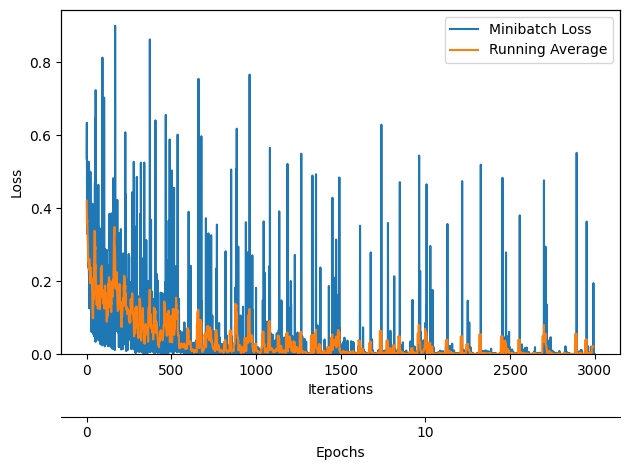

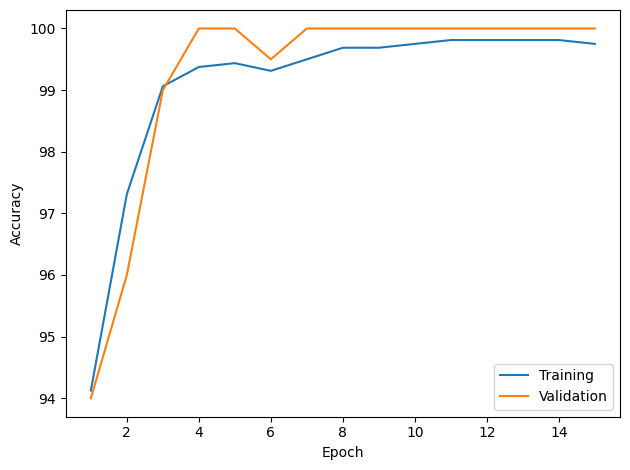

In [15]:
from utils.train import train_model
from utils.plot import plot_accuracy, plot_training_loss

model = model.to(DEVICE)
minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_dataloader,
    valid_loader=val_dataloader,
    test_loader=test_dataloader,
    optimizer=optimizer,
    checkpoint_prefix=CHECKPOINT_PREFIX,
    device=DEVICE,
    logging_interval=10)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_dataloader),
                   results_dir=None,
                   averaging_iterations=10)

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)

In [67]:
# Create prediction function for raw text
def predict_text(text, model, tokenizer, device):
    model.eval()
    inputs = tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=MAX_LENGTH).to(device)
    input_ids = inputs['input_ids']
    with torch.no_grad():
        logits = model(input_ids)
    return torch.argmax(logits, dim=-1).item()

In [68]:
count = 0
with open(os.path.join(REPORT_DIR, 'json_1.json')) as f:
    for line in f:
        data = json.loads(line)
        text = data['text']
        prediction = predict_text(text, model, tokenizer, DEVICE)
        print(f"label: {data['label']}, prediction: {prediction}")
        count += 1
        if count > 10:
            break

count = 0
with open(os.path.join(REPORT_DIR, 'json_19.json')) as f:
    for line in f:
        data = json.loads(line)
        text = data['text']
        prediction = predict_text(text, model, tokenizer, DEVICE)
        print(f"label: {data['label']}, prediction: {prediction}")
        count += 1
        if count > 10:
            break


label: 0, prediction: 0
label: 0, prediction: 0
label: 0, prediction: 0
label: 0, prediction: 0
label: 0, prediction: 0
label: 0, prediction: 0
label: 0, prediction: 0
label: 0, prediction: 0
label: 0, prediction: 0
label: 0, prediction: 0
label: 0, prediction: 0
label: 1, prediction: 1
label: 1, prediction: 1
label: 1, prediction: 1
label: 1, prediction: 1
label: 1, prediction: 1
label: 1, prediction: 1
label: 1, prediction: 1
label: 1, prediction: 1
label: 1, prediction: 1
label: 1, prediction: 1
label: 1, prediction: 1
